# sequana_coverage test case example (Bacteria Staphylococcus aureus)

This notebook uses as input a BED file called (FN433596.bed) provided in this repository (see after to download and bunzip it )

- https://github.com/sequana/resources/tree/master/coverage

The notebook shows that 
    - a constant threshold is not appropriate for bacterial genome where replication implies non-constant trend in the genome coverage. 
    - a moving average is better at following the trend but is impacted by the presence of deleted or duplicated regions. 
    - a running median is the best option to follow the trend while avoiding the presence of deleted/duplicated regions.
    
Sequana version used :
- sequana 0.6.5 see https://sequana.readthedocs.io for installation.


In [6]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [10,7]

Populating the interactive namespace from numpy and matplotlib


# Download data

In [2]:
!wget -c -N https://github.com/sequana/resources/raw/master/coverage/FN433596.bed.bz2 1>out 2>err
!bunzip2    FN433596.bed.bz2

# Sequana coverage (library)

Let us first look at the mapped data using Sequana library. We also detect the ROIs using our running median and mixture modle methodology

In [9]:
# from sequana import GenomeCov
b = GenomeCov("FN433596.bed")

In [3]:
# load the first chromosome and compute running median and get z-scores
chromosome = b.chr_list[0]
chromosome.run(30001, circular=True)

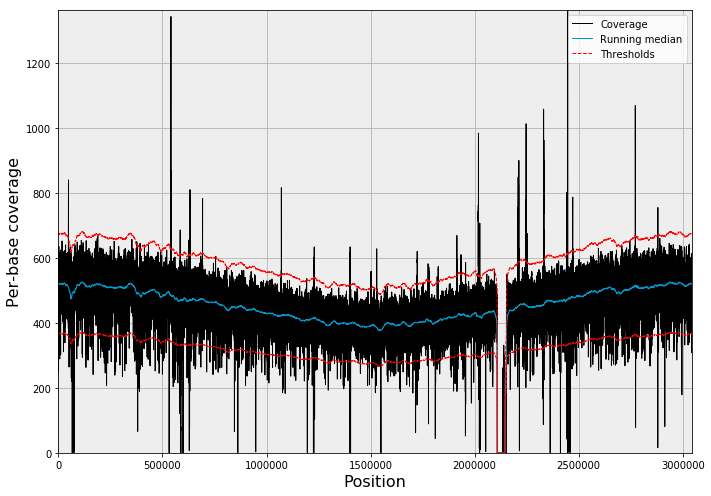

In [7]:
chromosome.plot_coverage()

Let us focus on the first 0.1Mb and plot the detected ROIs

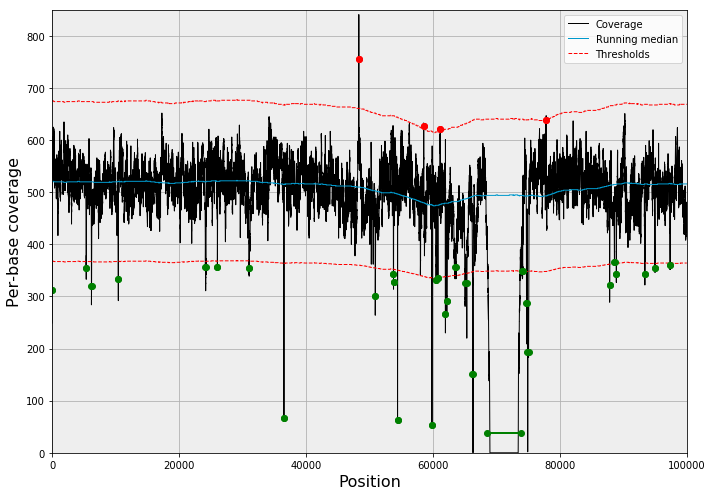

In [8]:
chromosome.plot_rois(0, 100000)
_ = ylim([0,850])

In this region of the genome, the red dashed lines show the adpatative thresholds obtained with the algorithm. Below and above are the detected ROIs.
The blue line indicates the running median. We see for example that the deteleted region at position 70,000 has no impact on 
the running median and the thresholds, which is the intended behaviour. 

# What about a constant threshold ?

Here, we hack the library to set the zscore values to 0 everywhere except above and below 600 and 400 respectively. When calling get_rois() method, 
it re-filters the data to extract the features and perform the clustering
based on the zscore. So it is as if we had used constant thresholds.

In [10]:
chromosome.df['zscore'] *= 0
DOC = chromosome.df['cov'].mean()
STD = 1.5 * chromosome.df['cov'].std()
chromosome.df.loc[chromosome.df['cov']>DOC+STD, 'zscore'] = 5
chromosome.df.loc[chromosome.df['cov']<DOC-STD, 'zscore'] = -5
print("DOC {}, shift={}".format(DOC, STD))

DOC 447.7471058520444, shift=126.14951990099274


In [11]:
rois = chromosome.get_rois()

In [12]:
# we've got lots of ROIs here. This of course depends on the thresholds
# fixed in the step above
len(rois)

5963

Here, we plot the coverage again; We can ignore the dashed lines (running median thresholds); instead we plot the horizontal lines at 321 and 573 and
the different detection. This is not too bas as compared to the plot above

In [26]:
x1 = 0
x2 = 100000
def plot_rois(x1,x2):
    chromosome.plot_coverage(x1=x1, x2=x2)
    high = rois.get_high_rois().query("end>@x1 and start<@x2")
    low = rois.get_low_rois().query("end>@x1 and start<@x2")
    for start, end, cov in zip(high.start, high.end, high.mean_cov):
        plot([start, end], [cov, cov], lw=2, color="r", marker="o")
    for start, end, cov in zip(low.start, low.end, low.mean_cov):
        plot([start, end], [cov, cov], lw=2, color="g", marker="o")
    ylim([0, 850])    
    axhline(DOC+STD, lw=3)
    axhline(DOC-STD, lw=3)

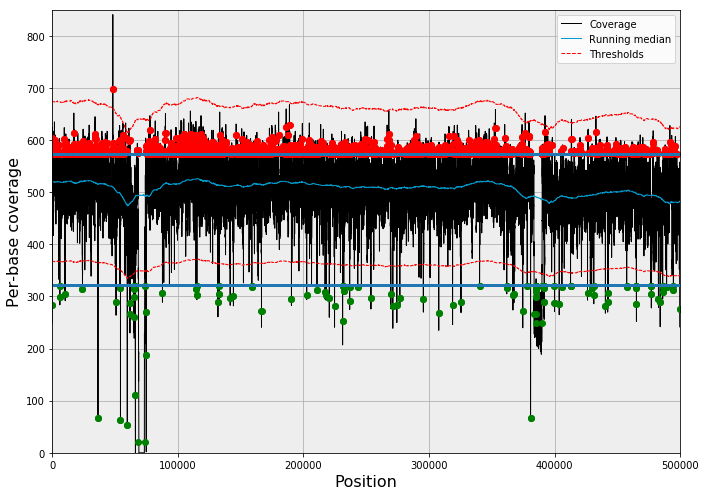

In [27]:
plot_rois(0,500000)

Keeping the same constant threshold, and looking at another part of the genome, there is a clear offset and this would not be correct
to use a constant threshold

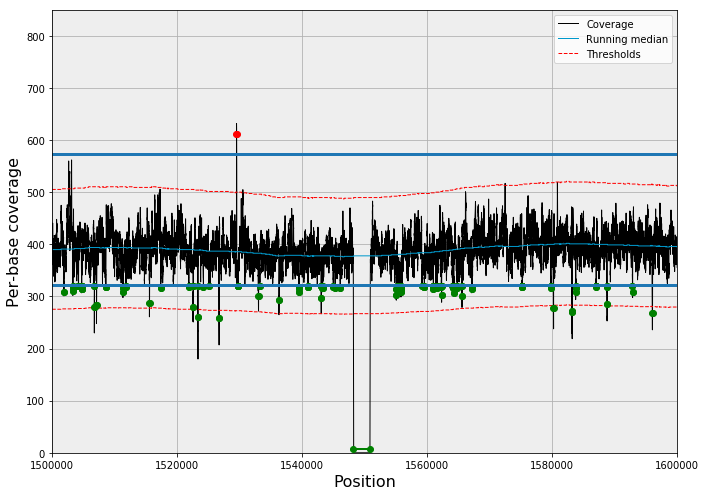

In [28]:
plot_rois(1500000,1600000)

**conclusion1: we need an adaptative threshold**

What about a rolling mean ? Why not but what would happen with CNVs, deleted regions, large outliers ? 
A running median is known to be insensitive to outliers. 

Let us inject 2 events for the illustration : one deletion and one depletion (half of the mean DOC)

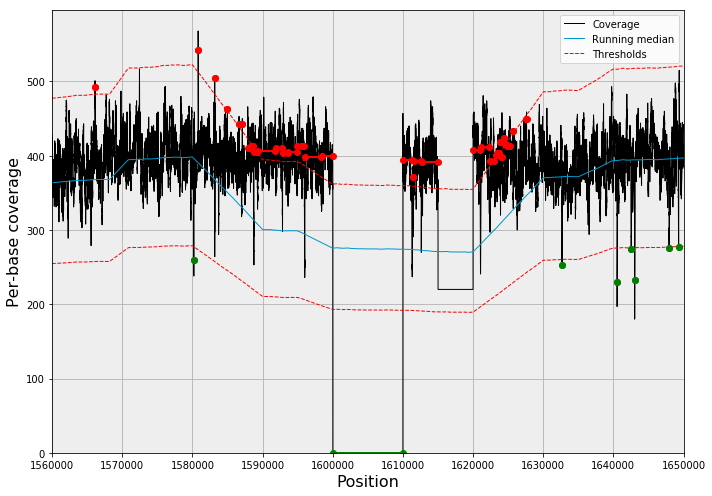

In [28]:
from sequana import GenomeCov
b = GenomeCov("FN433596.bed")
c = b.chr_list[0]
# We inject a deleted region of 15000 bases
c.df.loc[1600000:1610000, "cov"] *= 0
# and a region of 220 depth of coverage (hald the mean depth of coverage) closeby (5000 bases apart)
c.df.loc[1615000:1620000, "cov"] = 220

# here is a hack where we compute the median just to create the data structure 
c.running_median(40001, circular=True)
# and replace it with the moving average
c.moving_average(40001, circular=True)
c.df['rm'] = c.df['ma']

c.compute_zscore()
c.plot_rois(1560000, 1650000)



what we see here is that the deleted event is detected (possition 1600000 to 1615000).
However, the next event with coverage of 220 is missed !
Besides, we have lots of false detection (red dots), in particular the region between the deleted region, and the depleted region
is considered as a region of interest of 5000 bases ! 

So, what would happen with a running median:
    

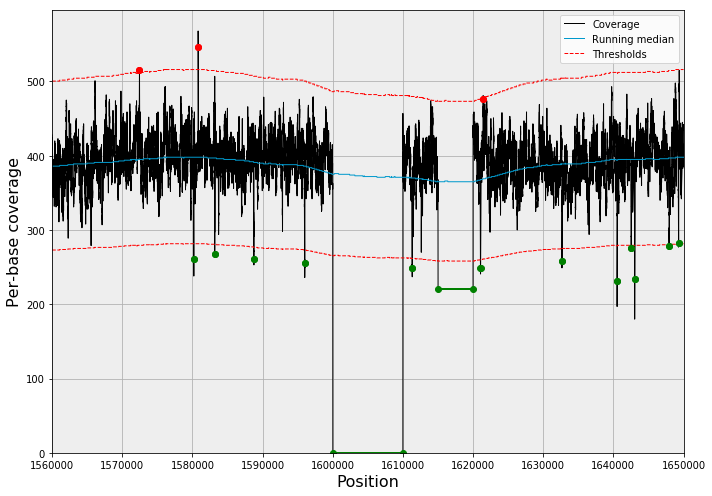

In [29]:
c.running_median(40001, circular=True)
c.compute_zscore()
c.plot_rois(1560000, 1650000)

Here we detect the two events, we do not have false alarms either. 

**Conclusion2: a median estimator is more robust than the moving average**